In [25]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib import colors 
import evaluation.evaluate as evaluate

In [26]:
np.random.seed(1)
tf.random.set_seed(1)

In [27]:
X_train, Y_train, trainFileList = bbdc.load_audioset("long_unbalanced_train_segments.csv", "unbalanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_validation, Y_validation, validationFileList = bbdc.load_audioset("long_balanced_train_segments.csv", "balanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")
X_test, Y_test, testFileList = bbdc.load_audioset("long_eval_segments.csv", "eval_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")

16186it [08:29, 31.77it/s]
573it [00:18, 31.05it/s]
585it [00:18, 31.54it/s]


In [28]:
Y_train[:,0]=0
Y_validation[:,0]=0
Y_test[:,0]=0

In [29]:
X_train_new = np.append(X_train, X_validation, axis=0)
X_train_new = np.append(X_train_new, X_test, axis=0)
Y_train_new = np.append(Y_train, Y_validation, axis=0)
Y_train_new = np.append(Y_train_new, Y_test, axis=0)

In [30]:
shuffledIndices = np.random.permutation(X_train_new.shape[0])
X_train_new = X_train_new[shuffledIndices]
Y_train_new = Y_train_new[shuffledIndices]
length = len(shuffledIndices)
X_validation_new = X_train_new[int(0.8*length):int(0.9*length)]
Y_validation_new = Y_train_new[int(0.8*length):int(0.9*length)]
X_test_new = X_train_new[int(0.9*length):]
Y_test_new = Y_train_new[int(0.9*length):]
X_train_new = X_train_new[:int(0.8*length)]
Y_train_new = Y_train_new[:int(0.8*length)]

In [42]:
channels = [50, 60]
numClasses=13

input_layer = layers.Input(shape=(None, 32))
x = input_layer
x = layers.Conv1D(channels[0], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.Conv1D(channels[0], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[1], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.Conv1D(channels[1], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D()(x)

x = layers.Conv1D(channels[0], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.Conv1D(channels[0], kernel_size=3, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Activation(keras.activations.softmax)(x)

model = keras.models.Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 32)]        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 50)          4850      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 50)          7550      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 50)          200       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 50)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 60)          9060      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 60)          1086

In [43]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train_new, Y_train_new, batch_size=10, epochs=8, shuffle=True, validation_data=(X_validation_new, Y_validation_new))

Epoch 1/8
1388/1388 [==============================] - 30s 21ms/step - loss: 2.0330 - mae: 0.1167 - accuracy: 0.3712 - val_loss: 1.7336 - val_mae: 0.1078 - val_accuracy: 0.4533
Epoch 2/8
1388/1388 [==============================] - 27s 20ms/step - loss: 1.5533 - mae: 0.0998 - accuracy: 0.5098 - val_loss: 1.6549 - val_mae: 0.0973 - val_accuracy: 0.4867
Epoch 3/8
1388/1388 [==============================] - 27s 20ms/step - loss: 1.3665 - mae: 0.0889 - accuracy: 0.5739 - val_loss: 1.4158 - val_mae: 0.0864 - val_accuracy: 0.5761
Epoch 4/8
1388/1388 [==============================] - 27s 19ms/step - loss: 1.2770 - mae: 0.0841 - accuracy: 0.5972 - val_loss: 1.2646 - val_mae: 0.0769 - val_accuracy: 0.6142
Epoch 5/8
1388/1388 [==============================] - 27s 20ms/step - loss: 1.2267 - mae: 0.0813 - accuracy: 0.6131 - val_loss: 1.3405 - val_mae: 0.0787 - val_accuracy: 0.5975
Epoch 6/8
1388/1388 [==============================] - 28s 20ms/step - loss: 1.1784 - mae: 0.0788 - accuracy: 0.619

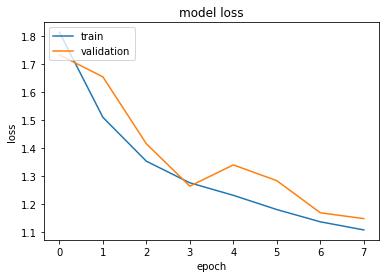

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

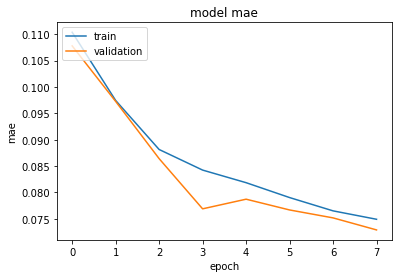

In [45]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

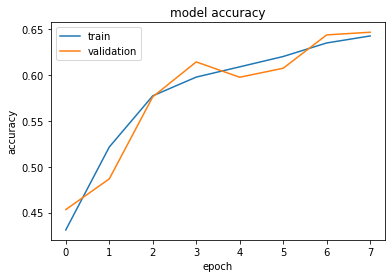

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
prediction = model.predict(X_test_new)
scores = model.evaluate(X_test_new, Y_test_new)

55/55 [==============================] - 1s 10ms/step - loss: 1.1904 - mae: 0.0744 - accuracy: 0.6277


In [48]:
index = 23
print(bbdc.invLabelMap[np.argmax(prediction[index])])
print(bbdc.invLabelMap[np.argmax(Y_test_new[index])])

Cheering
Fireworks


# Prediction der Test-Daten

In [89]:
madePrediction = pd.read_csv("../predictions/jannes/LP1d_PredictionChallenge_mel_probs3.csv")
pathToDataDir = "../data/"
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"
madePrediction.head()

,filename,onset,offset,event_label,MeanProb,MedianProb
0,10001_mix.wav,2.857143,3.834586,Cheering,0.921573,0.971862
1,10001_mix.wav,5.513784,6.466165,Church_bell,0.436819,0.443509
2,10002_mix.wav,0.476190,2.030075,Shout,0.641397,0.685553
3,10002_mix.wav,2.055138,3.483709,Fireworks,0.388373,0.359040
4,10002_mix.wav,5.137845,6.090226,Fireworks,0.874577,0.881943


In [91]:
currentFile = ""
X = []
Y = []
for index, row in madePrediction.iterrows():
    if currentFile!=row["filename"]:
        currentFile = row["filename"]
        features = np.genfromtxt(pathToDataDir + pathToDataset +"/eval/" + row["filename"].replace(".wav", ".csv"), delimiter=',')
    indices = np.logical_and(features[:,0]>=row["onset"], features[:,0]<=row["offset"])
    X.append(features[indices, 1:])
    Y.append(bbdc.LABEL_DICT[row["event_label"]])

In [92]:
secondPrediction = []
for i in range(len(X)):
    if X[i].shape[0]>=44:
        pred = np.argmax(model.predict(np.array([X[i]])))
        if pred==0:
            secondPrediction.append(Y[i])
        else:
            secondPrediction.append(pred)
    else:
        secondPrediction.append(Y[i])

In [93]:
secondLabel = [bbdc.invLabelMap[pred] for pred in secondPrediction]

In [94]:
secondPredictionDf = madePrediction.copy()
secondPredictionDf["event_label"]=secondLabel
secondPredictionDf.to_csv("../predictions/jannes/secondPrediction.csv", index=False)

In [87]:
evaluate.evaluate("../predictions/jannes/secondPrediction.csv", "./../data/test.csv")

(0.3599793820073489, 'Valid file')